## Instacart Market Basket Analysis - In-Depth Analysis Draft 2

Instacart is a technology company providing a same day delivery grocery service to users across the U.S and Canada. Users place their grocery orders through the Instacart app and a personal Instacart shopper delivers the order to their home.

Instacart made public an anonymized data of 3 million Instacart shoppers presenting researchers with the challenge of predicting which previously purchased products will be in the user’s next order. 

This report is the first draft of an in-depth analysis using different machine learning models on users and product features determined during the EDA stage. 

Files:
orders.csv <br>
order_products__prior.csv <br>
order_products__train.csv <br>
products.csv <br>
aisles.csv <br>
departments.csv <br>



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

In [2]:
# Reading csv files into Pandas DataFrames

filename_orders_file = 'files/orders.csv'
filename_products_prior = 'files/order_products__prior.csv'
filename_products_train= 'files/order_products__train.csv'
filename_products = 'files/products.csv'
filename_aisles = 'files/aisles.csv'
filename_departments = 'files/departments.csv'

orders = pd.read_csv(filename_orders_file)
order_products_prior = pd.read_csv(filename_products_prior)
order_products_train= pd.read_csv(filename_products_train)
products = pd.read_csv(filename_products) 
aisles = pd.read_csv(filename_aisles)
departments = pd.read_csv(filename_departments)

The 500th order was selected from the order_products_train.csv file and the matching order number from order_products_prior.csv was selected. 

The total number of orders in the subset is 3969 made by 255 user_id's. From those, 3714 are prior orders.

DataFrames:<br>
sample<br>
sample_orders_prior<br>
sample_orders_train<br>

In [3]:
#Forming subset of orders file. For this exercise, order_numbers that had both a prior and train data were selected.

# Orders with train eval_set are selected
orders_train = orders.loc[orders['eval_set'] == 'train']

# From the orders that had train data, every 400th row was selected to create a subset
sample_orders_train = orders_train[orders_train.index % 500 == 0]


# Prior orders are added to the sample
orders_sample = orders['user_id'].isin(sample_orders_train['user_id'])
sample = orders[orders_sample]
sample.describe()
print('The sample has', len(sample),'orders')
sample.head()

The sample has 3969 orders


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
14993,242494,940,prior,1,0,7,NaN
14994,1747069,940,prior,2,0,15,14.0
14995,402072,940,prior,3,5,8,26.0
14996,408253,940,prior,4,3,12,26.0
14997,542412,940,prior,5,0,12,4.0


In [4]:
sample_orders_prior = sample.loc[sample['eval_set'] == 'prior']
print('The sample has', len(sample_orders_prior),'prior orders')
sample_orders_prior.head()

The sample has 3714 prior orders


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
14993,242494,940,prior,1,0,7,NaN
14994,1747069,940,prior,2,0,15,14.0
14995,402072,940,prior,3,5,8,26.0
14996,408253,940,prior,4,3,12,26.0
14997,542412,940,prior,5,0,12,4.0


In [5]:
user_id_unique = sample['user_id'].unique()
print('The sample has' , len(user_id_unique), 'unique users')

The sample has 255 unique users


In [6]:
orders_unique = sample_orders_prior['order_id'].unique()
print('In the sample, 255 users made' , len(orders_unique), 'number of prior orders')

orders_unique_total = sample['order_id'].unique()
print('And' , len(orders_unique_total), 'of total orders when including train orders')

In the sample, 255 users made 3714 number of prior orders
And 3969 of total orders when including train orders


In [7]:
print('In average each user placed', (len(user_id_unique)/len(orders_unique))*100, 'prior orders.')

print('In average each user placed', (len(user_id_unique)/len(orders_unique_total))*100, 'orders.')

In average each user placed 6.8659127625201934 prior orders.
In average each user placed 6.424792139077853 orders.


The following section merges the DataFrames to create the product_merged_sample DataFrame with respective orders, products, departments, aisles, day of the week when the order was placed, time of the day, time since last order and whether it is a reordered product.

In [8]:
#Merging of order_products_prior with sub-sample. Creating orders_products_prior with 3714 prior orders and products 
#in each order.

orders_products_sample = order_products_prior['order_id'].isin(sample['order_id'])
orders_products_prior_sample = order_products_prior[orders_products_sample]
print(len(orders_products_prior_sample['order_id'].unique()))
orders_products_prior_sample.head(2)

3714


,order_id,product_id,add_to_cart_order,reordered
21206,2249,11365,1,1
21207,2249,43352,2,1


In [9]:
#product_merged_sample contains prior orders with user_id, product_name, department, aisle and timeline.

merged_order_sample = pd.merge(orders_products_prior_sample, sample, on='order_id', how='left')
product_merged = pd.merge(merged_order_sample, products, on='product_id',how='left')
product_aisle_merged = pd.merge(product_merged, aisles[['aisle','aisle_id']], on = 'aisle_id', how = 'left')
product_department_merged = pd.merge(product_aisle_merged, departments[['department','department_id']], on = 'department_id', how = 'left')
product_merged_sample = product_department_merged[['user_id','order_id','order_number','product_id','product_name','aisle','department','eval_set','add_to_cart_order', 'order_dow', 'order_hour_of_day','days_since_prior_order', 'reordered']]


In [10]:
orders_products_prior_sample.head(2)

,order_id,product_id,add_to_cart_order,reordered
21206,2249,11365,1,1
21207,2249,43352,2,1


In [11]:
product_merged_sample.head()

,user_id,order_id,order_number,product_id,product_name,aisle,department,eval_set,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,102271,2249,9,11365,Leaf Spinach,packaged produce,produce,prior,1,3,21,15.0,1
1,102271,2249,9,43352,Raspberries,packaged produce,produce,prior,2,3,21,15.0,1
2,102271,2249,9,8571,Baby Cucumbers,packaged produce,produce,prior,3,3,21,15.0,1
3,159768,2451,33,2113,Ultra Comfort Care Mega Roll Toilet Paper,paper goods,household,prior,1,2,17,3.0,1
4,159768,2451,33,42585,Organic Extra Firm Tofu,tofu meat alternatives,deli,prior,2,2,17,3.0,1


In [12]:
#Creating a DataFrame of reordered products

reordered_products_prior = product_merged_sample.loc[product_merged_sample['reordered'] == 1]
print('The number of reordered products is', len(reordered_products_prior))


The number of reordered products is 21976


# Product Features



In [13]:
#Creating a DataFrame with frequency of orders
#Creating a column 'order_frequency'

cnt_top_purchased = product_merged_sample['product_name'].value_counts().reset_index()
cnt_top_purchased.columns = ['product_name', 'order_frequency']
cnt_top_purchased


#Creating a column 'reorder_frequency' 

cnt_reordered_products = reordered_products_prior['product_name'].value_counts().reset_index()
cnt_reordered_products.columns = ['product_name', 'reorder_frequency']
cnt_reordered_products

#Merging top purchased products DataFrame with count of reordered products DataFrame 

merged_cnt = pd.merge(cnt_top_purchased, cnt_reordered_products, on='product_name', how='left')


#Ratio of order to reordered products

merged_cnt['reorder_ratio'] = (merged_cnt['reorder_frequency'] / merged_cnt['order_frequency'])*100

rounded_merged_cnt=np.round(merged_cnt, decimals=2)

sorted_merged_cnt = rounded_merged_cnt.sort_values(by='reorder_ratio',ascending = False)

sorted_merged_cnt.head()


,product_name,order_frequency,reorder_frequency,reorder_ratio
91,Original Almond Butter,48,47.0,97.92
160,Brownberry 100% 12 Grain Bread,32,31.0,96.88
53,"Red Onions, Fresh Diced",63,61.0,96.83
168,Organic Just Tart Cherry Juice,31,30.0,96.77
66,Natural Pure Sparkling Water,58,56.0,96.55


In [14]:
cart = product_merged_sample['order_id'].value_counts().reset_index()
cart.columns = ['order_id','items_in_shopping_cart']
cart.items_in_shopping_cart.describe()

count    3714.000000
mean        9.999731
std         7.245809
min         1.000000
25%         5.000000
50%         8.000000
75%        14.000000
max        57.000000
Name: items_in_shopping_cart, dtype: float64

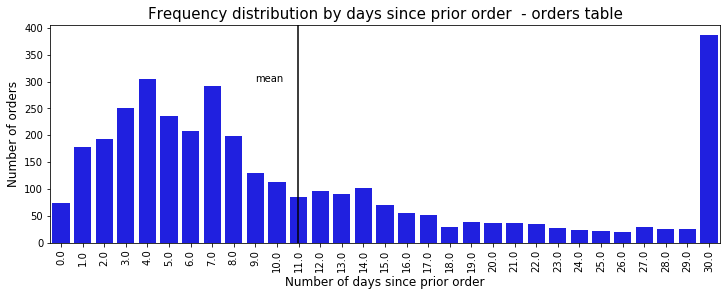

In [15]:
plt.figure(figsize=(12,4))
sns.countplot(x='days_since_prior_order', data=sample_orders_prior, color='b')
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Number of days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.axvline(np.mean(sample_orders_prior.days_since_prior_order), color='black')
plt.text(9,300,'mean', rotation=360, color='black')
plt.title("Frequency distribution by days since prior order  - orders table", fontsize=15)
plt.show()

                   number_reorders
add_to_cart_order                 
1                             3714
2                             3526
3                             3328
4                             3112
5                             2861


Text(0, 0.5, 'Reorder frequency')

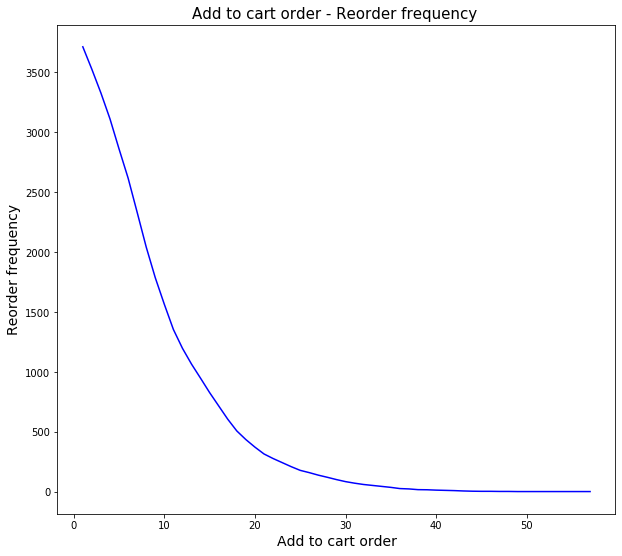

In [16]:
cart_order = pd.DataFrame()
cart_order['number_reorders'] = product_merged_sample.groupby('add_to_cart_order')['reordered'].size()
print(cart_order.head())
plt.figure(figsize=(10,9))
plt.plot(cart_order.number_reorders, color='b')
plt.title('Add to cart order - Reorder frequency ', fontsize='15')
plt.xlabel('Add to cart order',fontsize='14')
plt.ylabel('Reorder frequency', fontsize='14')

In [17]:
cart_order.head()
cart_order['product_avg_number_reorders'] = cart_order['number_reorders']/np.sum(cart_order['number_reorders'])*100
cart_order.head(2)

,number_reorders,product_avg_number_reorders
add_to_cart_order,,
1,3714,10.000269
2,3526,9.494063


# user features

In [18]:
usr = pd.DataFrame()
usr['user_average_days_between_orders'] = sample_orders_prior.groupby('user_id')['days_since_prior_order'].mean()
usr['user_number_orders'] = sample_orders_prior.groupby('user_id').size()
usr.head(2)

,user_average_days_between_orders,user_number_orders
user_id,,
940,18.166667,7
4915,13.909091,12


In [19]:
users = pd.DataFrame()
users['user_total_items'] = product_merged_sample.groupby('user_id').size()
users['user_all_products'] = product_merged_sample.groupby('user_id')['product_id'].apply(set)
users['user_total_distinct_items'] = (users.user_all_products.map(len))
users.head()
users['user_total_items'].sum()
users.head(2)

,user_total_items,user_all_products,user_total_distinct_items
user_id,,,
940,88,"{15872, 25601, 19202, 45698, 40332, 38028, 317...",58
4915,194,"{11266, 13829, 47626, 10, 6669, 49683, 12320, ...",91


In [20]:
users = users.join(usr)
del usr
users['user_average_basket'] = (users.user_total_items / users.user_number_orders)
print('user f', users.shape)

user f (255, 6)


In [21]:
users.head(2)


,user_total_items,user_all_products,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket
user_id,,,,,,
940,88,"{15872, 25601, 19202, 45698, 40332, 38028, 317...",58,18.166667,7,12.571429
4915,194,"{11266, 13829, 47626, 10, 6669, 49683, 12320, ...",91,13.909091,12,16.166667


In [22]:
product_merged_sample.iloc[:,11].fillna(product_merged_sample.iloc[:,11].mean(), inplace = True)
#sorted_merged_cnt.iloc[:,2] = sorted_merged_cnt.iloc[:,2].replace('nan', np.nan).fillna(0)
sorted_merged_cnt.iloc[:,2] = sorted_merged_cnt.iloc[:,2].replace('nan', np.nan).fillna(method='ffill')

In [23]:
avg_order_time = pd.DataFrame()
avg_order_time['avg_days_since_prior_order'] = product_merged_sample.groupby('product_name')['days_since_prior_order'].mean()
avg_order_merged = pd.merge(avg_order_time,sorted_merged_cnt, on='product_name' )
avg_order_merged.iloc[:,4] = avg_order_merged.iloc[:,4].replace('nan', np.nan).fillna(0)
#avg_order_merged.iloc[:,4] = avg_order_merged.iloc[:,4].replace('nan', np.nan).fillna(method='ffill')
avg_order_merged.head(2)

,product_name,avg_days_since_prior_order,order_frequency,reorder_frequency,reorder_ratio
0,#2 Coffee Filters,17.5,2,1.0,50.0
1,0% Fat Free Organic Milk,9.0,2,1.0,50.0


Text(0.5, 1.0, 'avg_days_since_prior_order vs. reorder_frequency')

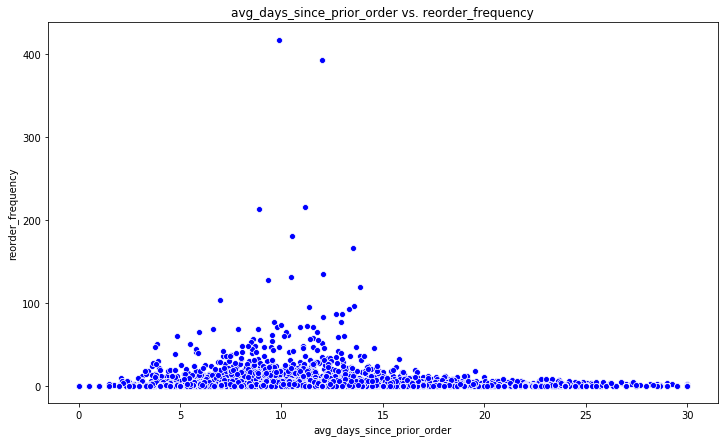

In [24]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=avg_order_merged,x='avg_days_since_prior_order', y='reorder_frequency', color='blue' ) 
plt.title('avg_days_since_prior_order vs. reorder_frequency')

In [25]:
avg_day_of_week = pd.DataFrame()
avg_day_of_week['product_avg_day_of_week'] = product_merged_sample.groupby('product_name')['order_dow'].mean()
avg_day_of_week.head()

,product_avg_day_of_week
product_name,
#2 Coffee Filters,5.0
0% Fat Free Organic Milk,0.5
0% Fat Organic Greek Vanilla Yogurt,1.0
0% Greek Strained Yogurt,2.2
0% Greek Yogurt Black Cherry on the Bottom,1.0


# Merging features table

In [26]:
product_features = pd.merge(product_merged_sample, avg_order_merged, on='product_name')
product_features = pd.merge(product_features, cart_order, on='add_to_cart_order')
product_features = pd.merge(product_features, users, on='user_id')
product_features = pd.merge(product_features, avg_day_of_week, on='product_name' )
product_features = product_features.drop(['product_name','aisle','eval_set','department','user_all_products',
'user_total_distinct_items' ],axis=1)
product_features = product_features.rename(columns={'avg_days_since_prior_order': 'product_avg_days_since_prior_order', 'reorder_frequency': 'product_reorder_frequency','reorder_ratio':'product_reorder_ratio'})
product_features = product_features.sort_values(by='user_id')
#product_features.set_index('user_id', inplace=True)
#product_features.isnull().sum()
product_features.head(2)


,user_id,order_id,order_number,product_id,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,reordered,product_avg_days_since_prior_order,order_frequency,product_reorder_frequency,product_reorder_ratio,number_reorders,product_avg_number_reorders,user_total_items,user_average_days_between_orders,user_number_orders,user_average_basket,product_avg_day_of_week
34555,940,408253,4,5618,21,3,12,26.0,0,16.250000,4,2.0,50.00,315,0.848165,88,18.166667,7,12.571429,2.250000
23820,940,1317198,7,31759,1,3,11,9.0,1,10.254697,29,20.0,68.97,3714,10.000269,88,18.166667,7,12.571429,2.896552


In [27]:
from sklearn import preprocessing
# Get column names first
names = product_features.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_product_features = scaler.fit_transform(product_features)
scaled_product_features = pd.DataFrame(scaled_product_features, columns=names)
scaled_product_features.head(2)

,user_id,order_id,order_number,product_id,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,reordered,product_avg_days_since_prior_order,order_frequency,product_reorder_frequency,product_reorder_ratio,number_reorders,product_avg_number_reorders,user_total_items,user_average_days_between_orders,user_number_orders,user_average_basket,product_avg_day_of_week
0,-1.76973,-1.355806,-0.709038,-1.401815,1.910909,0.122676,-0.319076,1.703930,-1.203876,1.010121,-0.470537,-0.448894,-0.329987,-1.760368,-1.760368,-0.983276,1.076934,-0.992513,-0.016169,-0.502601
1,-1.76973,-0.428554,-0.529185,0.463995,-1.057336,0.122676,-0.545548,-0.272861,0.830650,-0.224924,-0.187236,-0.198789,0.352479,1.266402,1.266402,-0.983276,1.076934,-0.992513,-0.016169,0.152616


# Splitting Data in Train and Test

In [28]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
Xtrain, Xtest, ytrain, ytest = train_test_split(scaled_product_features[['user_id','order_id', 'product_id','add_to_cart_order',
                                                                'days_since_prior_order','order_dow','product_avg_day_of_week','product_avg_days_since_prior_order',
                                                               'order_frequency',  'product_reorder_frequency',                                                  
                                                                'product_avg_number_reorders', 'user_number_orders','user_total_items',
                                                                'user_average_days_between_orders', 'product_reorder_ratio',
                                                                 'user_average_basket']].values, 
                                              (product_features.reordered).values,random_state=42)



# Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(solver='lbfgs',C=.1)
#Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)
#Print the accuracy from the testing data.
print("Accuracy:", accuracy_score(clf.predict(Xtest), ytest))

Accuracy: 0.7731825525040388


In [30]:
from sklearn.model_selection import KFold

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [31]:
clf = LogisticRegression(solver='lbfgs')
score = cv_score(clf, Xtrain, ytrain)
print("Accuracy:",score)

Accuracy: 0.7640911336502476


In [32]:
Cs = [0.001, 0.1, 1, 10]

max_score = 0

for C in Cs:
                                              
    clf = LogisticRegression(solver='lbfgs', C=C)
    score = cv_score(clf, Xtrain, ytrain)
    
    
    if score > max_score:
        max_score = score
        av_score = max_score
        C_highest = C

print(av_score, C_highest)

0.7643065606160654 0.1


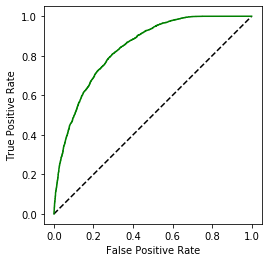

In [33]:
from sklearn.metrics import roc_curve, auc

y_score = clf.predict_proba(Xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')

# XGBoost Model

In [34]:
import sys
!{sys.executable} -m pip install xgboost

In [35]:
from numpy import loadtxt
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(Xtrain, ytrain)

# make predictions for test data
y_pred = model.predict(Xtest)
predictions = [round(value) for value in y_pred]


# evaluate predictions
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.60%


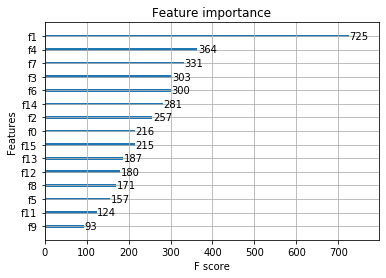

In [36]:
from xgboost import plot_importance
# Plot feature importance
plot_importance(model)

Training Data Accuracy: 0.90
Test Data Accuracy:     0.83
[[2619 1065]
 [ 551 5050]]


Precision:              0.83
Recall:                 0.90


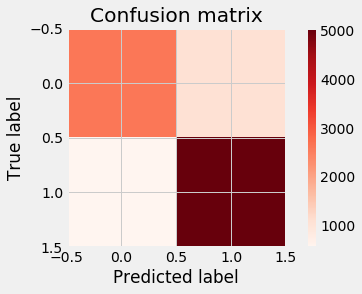

In [37]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
plt.style.use('fivethirtyeight')

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#y_tr=np.ravel(y_tr)

train_acc=model.score(Xtrain,ytrain)
test_acc=model.score(Xtest, ytest)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))
    
y_true = ytest
y_pred = model.predict(Xtest)


conf = confusion_matrix(y_true, y_pred)
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_pred, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

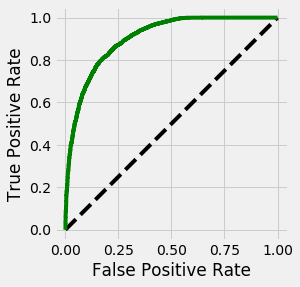

In [38]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(Xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')

# Random Forest Model

In [39]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 50)
classifier.fit(Xtrain, ytrain)

y_pred = classifier.predict(Xtest)

Confusion Matrix:
[[2603 1081]
 [ 711 4890]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.74      3684
           1       0.82      0.87      0.85      5601

    accuracy                           0.81      9285
   macro avg       0.80      0.79      0.79      9285
weighted avg       0.81      0.81      0.80      9285

Accuracy: 0.8070005385029617


Precision:              0.82
Recall:                 0.87


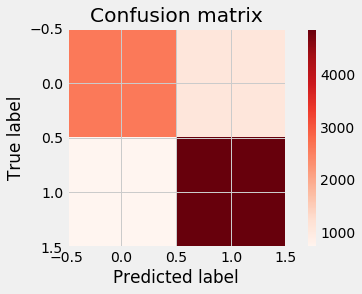

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(ytest, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(ytest, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(ytest,y_pred)
print("Accuracy:",result2)


def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ytest
y_pred = classifier.predict(Xtest)


conf = confusion_matrix(y_true, y_pred)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_pred, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

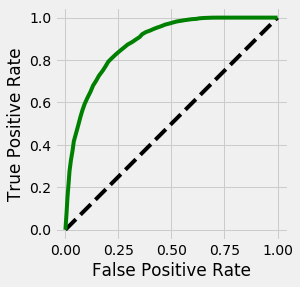

In [42]:

from sklearn.metrics import roc_curve, auc

y_score = classifier.predict_proba(Xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')